## Network Simulation

In [58]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

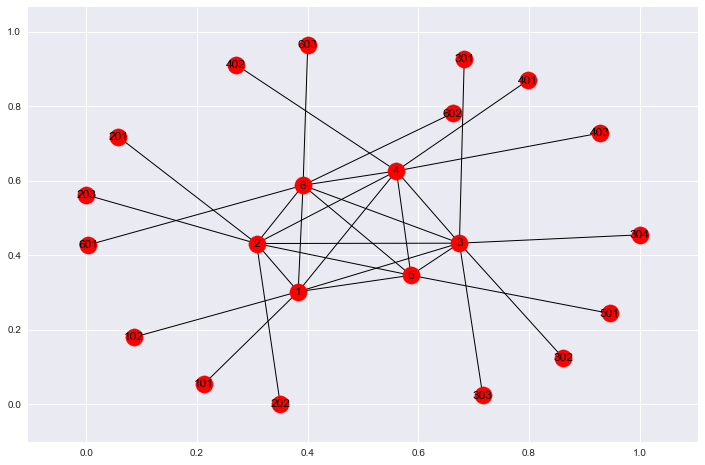

In [74]:
def draw_nw(num_of_hub, exp_spoke):
    
    num_of_spoke = np.random.normal(exp_spoke,1,num_of_hub)
    num_of_spoke = list(map(round, num_of_spoke))
    hub = list(range(1,num_of_hub+1))

    nw = nx.Graph()
    nw.add_nodes_from(hub, label = "Hub")
    hub_edges = np.array(list(itr.combinations(hub,2)))
    nw.add_edges_from(hub_edges, label = "Hub_edges")


    ##Assuming that customers cannot fly from a spoke to a spoke directly. They have to stop at a hub. 

    for i, h in enumerate(hub):
        num_of_s = int(num_of_spoke[i])
        spokes = [(h*100 + a) for a in range(1,num_of_s+1)]
        nw.add_nodes_from(spokes, label = "spokes of hub " + str(h) )
        edge_to_hub = [(h, s) for s in spokes ]
        nw.add_edges_from(edge_to_hub, label = "Spoke_edges" )
        
    return nw
nw = draw_nw(6,2)    
plt.figure(figsize = (12,8))
nx.draw_networkx(nw)
plt.show()

## Network Dataset Constructing

In [75]:
itin = np.array(list(itr.combinations(nx.nodes(nw),2)))

In [76]:
import pandas as pd
df_itin = pd.DataFrame({'itinenary': list(map(tuple, itin))})
df_itin.head(5)

,itinenary
0,"(1, 2)"
1,"(1, 3)"
2,"(1, 4)"
3,"(1, 5)"
4,"(1, 6)"


In [77]:
def clr(tup):
    a = tup[0]
    b = tup[1]
    if (a < 100 and b>= 100) or (a >= 100 and b < 100):
        return 'spoke-hub'
    elif a < 100 and b < 100:
        return 'hub-hub'
    elif a >= 100 and b >= 100:
        return 'spoke-spoke'

In [78]:
itin_type = list(map(clr, df_itin['itinenary']))
df_itin['type'] = itin_type

In [79]:
def path_len(G, tup):
    a = tup[0]
    b = tup[1]
    return nx.shortest_path_length(G,a,b)

paths = list(map(lambda x: path_len(nw, x), df_itin['itinenary']))

In [80]:
df_itin['length'] = paths

In [81]:
def price(row):
    #hub to spoke
    h_s_mean = 0.7
    h_s_var = 0.08
    
    #spoke to hub to spoke
    s_h1_s_mean = 0.9
    s_h1_s_var = 0.08
    
    #hub to hub
    h_h_mean = 1.0
    h_h_var = 0.1

    #hub to hub to spoke
    h_h_s_mean = 1.3
    h_h_s_var = 0.1
    
    #spoke to hub to hub to spoke
    s_h2_s_mean = 1.5
    s_h2_s_var = 0.1
     
    
    if row[1] == 'hub-hub':
        return np.random.lognormal(h_h_mean, h_h_var)*100
    elif row[2] == 2 and row[1] == 'spoke-spoke':
        return np.random.lognormal(s_h1_s_mean, s_h1_s_var)*100
    elif row[2] == 2 and row[1] == 'spoke-hub':
        return np.random.lognormal(h_h_s_mean, h_h_s_var)*100
    elif row[1] == 'spoke-hub':
        return np.random.lognormal(h_s_mean, h_s_var)*100
    elif row[2] == 3:
        return np.random.lognormal(s_h2_s_mean, s_h2_s_var)*100
    
    

In [82]:
df_itin['fare1'] = df_itin.apply(price, axis = 1)

In [83]:
s_h2_s = df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 3].fare1.mean()
s_h1_s = df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 2].fare1.mean()
h_s = df_itin[df_itin.type == 'spoke-hub'][df_itin.length == 1].fare1.mean()
h_h_s = df_itin[df_itin.type == 'spoke-hub'][df_itin.length == 2].fare1.mean()
h_h = df_itin[(df_itin.type == 'hub-hub')].fare1.mean()

print('The average fare (class1) of a hub to spoke is ', round(h_s, 2))
print('The average fare (class1) of a spoke to hub to spoke is ', round(s_h1_s, 2))
print('The average fare (class1) of a hub to hub is ', round(h_h, 2))
print('The average fare (class1) of a hub to hub to spoke is ', round(h_h_s, 2))
print('The average fare (class1) of a spoke to hub to hub to spoke is ', round(s_h2_s, 2))



The average fare (class1) of a hub to spoke is  201.19
The average fare (class1) of a spoke to hub to spoke is  249.11
The average fare (class1) of a hub to hub is  264.02
The average fare (class1) of a hub to hub to spoke is  363.3
The average fare (class1) of a spoke to hub to hub to spoke is  449.65


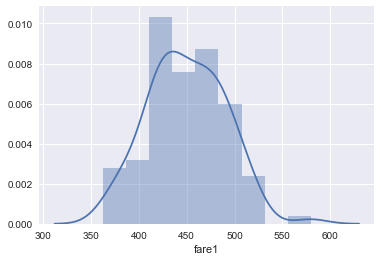

In [84]:
## Plot the price distritbution
sns.distplot(df_itin[df_itin.type == 'spoke-spoke'][df_itin.length == 3].fare1)

In [85]:
df_itin['fare2'] = df_itin['fare1']*1.5
df_itin['fare3'] = df_itin['fare1']*2.5

df_fare = df_itin[['fare1', 'fare2', 'fare3']]
df_itin.head(5)

,itinenary,type,length,fare1,fare2,fare3
0,"(1, 2)",hub-hub,1,280.863806,421.295709,702.159515
1,"(1, 3)",hub-hub,1,219.798944,329.698416,549.497360
2,"(1, 4)",hub-hub,1,255.333156,382.999733,638.332889
3,"(1, 5)",hub-hub,1,266.960010,400.440015,667.400025
4,"(1, 6)",hub-hub,1,296.530373,444.795559,741.325932


In [89]:
## constructing leg-itinenary matrix
itin_path = df_itin.itinenary

df_leg = df_itin[df_itin.length == 1]
df_leg.reset_index(drop = True, inplace = True)
df_leg.rename(columns = {'itinenary': 'leg'}, inplace = True)

leg_path = df_leg.leg

## Random capacity for each flight leg
cap_mean = 0.9
cap_var = 0.3

def rand_cap(s):
    if s == 'hub-hub':
        return int(round(np.random.lognormal(cap_mean*1.15, cap_var*1.2)))
    else:
        return int(round(np.random.lognormal(cap_mean, cap_var)))

df_leg['capacity'] = list(map(rand_cap, df_leg.type ))

df_leg.head(5)

,leg,type,length,fare1,fare2,fare3,capacity
0,"(1, 2)",hub-hub,1,280.863806,421.295709,702.159515,2
1,"(1, 3)",hub-hub,1,219.798944,329.698416,549.497360,2
2,"(1, 4)",hub-hub,1,255.333156,382.999733,638.332889,4
3,"(1, 5)",hub-hub,1,266.960010,400.440015,667.400025,3
4,"(1, 6)",hub-hub,1,296.530373,444.795559,741.325932,3


In [90]:
test = itin_path[6]
def leg_in_itin(itin, legs):
    a = itin[0]
    b = itin[1]
    
    short_paths = nx.shortest_path(nw, a, b)
    l1 = []
    for i in range(len(short_paths) -1 ):
        l1.append((short_paths[i],short_paths[i+1]))
        
    e = [0]*len(legs)
    for j in l1:
        e += (j == legs)*1

    return e


#leg_in_itin(itin_path[0], leg_path)
def E_df(leg_path, itin_path):
    m = np.matrix(list(map(lambda x: leg_in_itin(x, leg_path), itin_path)))
    df = pd.DataFrame(m, index = itin_path, columns = leg_path)
    return df
df_e = E_df(leg_path, itin_path)
df_full = pd.concat([df_itin, df_e.reset_index(drop = True)], axis = 1)

### Dataset notations: 
Columns：
- Itinenary: list of all itinenaries between every two nodes in the network
- Type: <br>
hub-hub -> itinenaries between two hubs <br>
spoke-hub -> itinenaries between two spoke and hub <br>
spoke-spoke -> itinenaries between two spokes <br>
- Fare i: Ticket Price for fare class i
- Flight legs (0-1 matrix): = 1 if leg i in itinenary j, and = 0, otherwise. 

In [91]:
df_full.head(8)

,itinenary,type,length,fare1,fare2,fare3,"(1, 2)","(1, 3)","(1, 4)","(1, 5)",...,"(4, 5)","(4, 6)","(4, 401)","(4, 402)","(4, 403)","(5, 6)","(5, 501)","(6, 601)","(6, 602)","(6, 603)"
0,"(1, 2)",hub-hub,1,280.863806,421.295709,702.159515,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(1, 3)",hub-hub,1,219.798944,329.698416,549.497360,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"(1, 4)",hub-hub,1,255.333156,382.999733,638.332889,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,"(1, 5)",hub-hub,1,266.960010,400.440015,667.400025,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"(1, 6)",hub-hub,1,296.530373,444.795559,741.325932,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"(1, 101)",spoke-hub,1,204.262344,306.393516,510.655861,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"(1, 102)",spoke-hub,1,216.443632,324.665448,541.109080,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"(1, 201)",spoke-hub,2,400.943319,601.414978,1002.358297,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Linear Program

\begin{equation*}
Maximize
\sum_{t \ \in \ T} 
\sum_{k \ \in \ K}
\sum_{j \ \in \ J}
f_{jk} \  
w_{jkt}
\end{equation*}

\begin{equation*}
Subject\ to:\ C_i - 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
 \\ + 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t - L)
(1-p)(1-\pi)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
\geq 0
\, 
\forall \ i \ \in \ N
\ ,
\forall \ t \ \in \ T
\\
w_{jkt} 
\leq
\lambda_{jkt}
\\
f_{jk} = p\ r_{jk} + (1 - p)\ (u + \pi\ r_{jk})
\end{equation*}

$f_{jk}:$ The expected revenue from itinenary j for fare class j. <br>
$w_{jkt}:$ (Decision variable) The probability that we will accept a request for itinenary j with fare class k at time t. <br>
$e_{ji}:$ If flight leg i in itinenary j, $e_{ji}$ = 1. Otherwise, $e_{ji}$ = 0 <br>
$C_{i}:$ Capacity of flight leg i. <br>
$\mathbf{1}:$ Decision function. $\mathbf{1}(a)$ = 1 if $a \leq 0$. $\mathbf{1}(a)$ = 0, otherwise. <br>
$\lambda_{jkt}$: The probability that a customer is insterest in itinenary j with fare class k at time t. <br>
$r_{jk}$: Ticket price for itinenary j with fare class k <br>

$T:$ All the time periods. <br>
$K:$ All the fare classes. <br>
$J:$ All the itinenaries. <br>
$N:$ All the flight legs. <br>
$L:$ The time a customer can lock for the fare. <br>
$p:$ Probability that a customer purchased a ticket directly. <br>
$1 - p:$ Probability that a customer locked a ticket. <br>
$\pi :$ Prabability that a customer finally bought the ticket that he locked <br>

In [92]:
## Assuming only one customer in each time interval
num_of_time = 40
num_of_class = 3
num_of_itin = len(itin_path)
num_of_leg = len(leg_path)

T = list(range(num_of_time))
K = list(range(num_of_class))
J = list(range(num_of_itin))
N = list(range(num_of_leg))

## Time to lock
L = 3

## E[j][i] = 1 if leg i is in itinenary j
E = np.array(df_e)

## C[i]: Capacity remained on leg i
C = list(df_leg.capacity)

## p: Probability that a customer purchased a ticket directly
## 1 - p: Probability that a customer locked a ticket
p = 0.5

#pi : Prabability that a customer finally bought the ticket that he locked
pi = 0.4

#R[j][k]: fare of itinenary j with fare class k
R = np.matrix(df_fare)

#u: fee for fare-locking
u = 20

## F[j][k]: expected revenue from itinenary j with fare class k
F = np.array(p*R + (1 - p)*(u + pi*R))

##lmd[j][k][t]: Probability of a customer interest in itinenary j with fare-class k at time t
lmd = [[np.random.uniform(0.2, 1, num_of_time) for i in K] for j in J]

##Decision function
def one(a):
    if a:
        return 1
    else: 
        return 0

In [93]:
from gurobipy import *

In [94]:
model = Model("network")

## create decision variables 
W = [[[ 0 for t in T] for k in K ] for j in J]

for t in T:
    for k in K:
        for j in J:
            W[j][k][t] = model.addVar( vtype = GRB.CONTINUOUS, 
                                        name = "W_" + str(j) + "_" + str(k) + "_" + str(t))
            
model.update()

\begin{equation*}
Maximize
\sum_{t \ \in \ T} 
\sum_{k \ \in \ K}
\sum_{j \ \in \ J}
f_{jk} \  
w_{jkt}
\end{equation*}


In [95]:
## create a linear expression of the objective 
objExpr = LinExpr()
for t in T:
    for k in K:
        for j in J:
            objExpr += F[j][k] * W[j][k][t]
model.setObjective(objExpr, GRB.MAXIMIZE)

\begin{equation*}
\ C_i - 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
+ 
\sum_{s \ \in \ T}
\sum_{k \ \in \ K}
\mathbf{1}(s \leq t - L)
(1-p)(1-\pi)
\sum_{j \ \in \ J}
w_{jkt} \ 
e_{ji} 
\geq 0
\ , 
\forall \ i \ \in \ N
\ ,
\forall \ t \ \in \ T
\end{equation*}


In [96]:
## create constraints for capacity
for t in T:
    for i in N:
        constExpr = LinExpr()
        for s in T:
            for k in K:
                for j in J:
                    constExpr += one(s <= t)*W[j][k][t]*E[j][i] + one(s <= t - L)*(1 - p)*(1 - pi)*W[j][k][t]*E[j][i]
        model.addConstr(lhs = constExpr, sense = GRB.LESS_EQUAL, rhs = C[i],
                        name = 'capacity_on_leg_' + str(i) + 'at_' + str(t))
    
model.update()

\begin{equation*}
w_{jkt} 
\leq
\lambda_{jkt}
\end{equation*}

In [97]:
## create constraints for W
for t in T:
    for k in K:
        for j in J:
            descison_var = LinExpr()
            decision_var = W[j][k][t]
            
            bound = LinExpr()
            bound = lmd[j][k][t]
            
            model.addConstr(lhs = decision_var, sense = GRB.LESS_EQUAL, rhs = bound, 
                            name = 'prob_' + str(j)  + "_" + str(k) + "_" + str(t))
            
model.update()

In [98]:
## Write the model in a file
model.write(filename = "testOutput.lp")

In [99]:
## print optimal ojective and optimal solution
model.optimize()

Optimize a model with 28960 rows, 27720 columns and 72600 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+02, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 28824 rows and 26201 columns
Presolve time: 0.10s
Presolved: 136 rows, 1519 columns, 2578 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.430e+02
 Factor NZ  : 3.940e+02 (roughly 1 MByte of memory)
 Factor Ops : 1.632e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.14882041e+06  8.15520450e+05  1.59e+02 2.95e+02  2.34e+03     0s
   1   2.60950965e+05  6.18873799e+05  9.50e+00 6.82e-13  2.72e+02     0s
   2   1.54608114e+05  2.67902978e+05  8.13e-01 5.68e-13  4.52e+01     0s
   3   1.52743374e+05  1.98655365e

In [100]:
## print optimal objective and optimal solution
print("\nOptimal Objedctive: " + str(model.Objval))
print("\nOptimal Solution(first 10):")
allVars = model.getVars()
for curVar in allVars[:10]:
    print(curVar.varname + " " + str(curVar.x))


Optimal Objedctive: 162371.3784472317

Optimal Solution(first 10):
W_0_0_0 0.0
W_1_0_0 0.0
W_2_0_0 0.24845516857711625
W_3_0_0 0.7829327162829316
W_4_0_0 0.7284673803493786
W_5_0_0 0.0
W_6_0_0 0.0
W_7_0_0 0.0
W_8_0_0 0.0
W_9_0_0 0.0
